<a href="https://colab.research.google.com/github/emmayeh-0211/2021AI_dl/blob/main/transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 掛載 google 雲端硬碟
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 解壓縮
import zipfile
fn = '/content/drive/MyDrive/train.zip'
zf = zipfile.ZipFile(fn)
zf.extractall()

(483, 500)


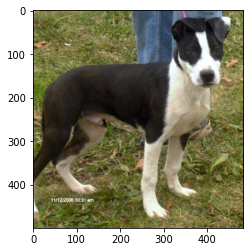

In [62]:
# 看一下圖庫裡面的圖片長什麼樣子
import glob
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

fns = glob.glob('train/*')
num = random.randint(1, len(fns))
img = Image.open(fns[num])
print(img.size)
plt.imshow(img)

In [19]:
import pandas as pd
dogf = glob.glob('train/dog.*')
catf = glob.glob('train/cat.*')
data = pd.DataFrame({
    'path': dogf + catf,
    'target': [0] * len(dogf) + [1] * len(catf) # dog代表0、cat代表1
})
print(data.shape)
data.head()


(25000, 2)


,path,target
0,train/dog.10694.jpg,0
1,train/dog.4214.jpg,0
2,train/dog.1140.jpg,0
3,train/dog.7814.jpg,0
4,train/dog.456.jpg,0


In [28]:
# 如果要在colab用特殊的tensorflow版本，可以用%...
# colab 預設是tensorflow2
# 建模方法一
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
t1 = GlobalAveragePooling2D()(vgg.output)
out = Dense(2, activation='softmax')(t1)
model = Model(inputs=vgg.input, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [35]:
# 建模方法二：使用sequntial，限制一定是一層疊一層
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
# 每一層的trainable預設是True，就是可訓練的，
# 但遷移學習我們希望借過來的模型不要重新訓練裡面的參數，直接照搬過來用，所以這邊要關成False
# trainable設定一定要在compile之前
for l in vgg.layers:
  l.trainable = False 
layers = [
          GlobalAveragePooling2D(),
          Dense(2, activation='softmax')
]
model = Sequential(vgg.layers + layers)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [36]:
# 將模型最後進行compile，透過稀疏矩陣，減少消耗的ram
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer=Adam(),
              metrics=["accuracy"])

In [58]:
test = np.random.randint(0, 5, size=(5, 3, 3, 2))
# print(test)
print(test.shape)
print('-' * 10)
print('我要取第一維：0 裡面的 第二維：1 裡面的 第三維:0  裡面的 數值\n', test[0, 1, 0]) # np.array[第一個軸要哪幾個, 第二個要哪幾個...]
print('我要取第一維：全部 裡面的 第二維：全部 裡面的 第三維:全部  裡面的 數值\n', test[:,:,:,0])

(5, 3, 3, 2)
----------
我要取第一維：0 裡面的 第二維：1 裡面的 第三維:0  裡面的 數值
 [3 4]
我要取第一維：全部 裡面的 第二維：全部 裡面的 第三維:全部  裡面的 數值
 [[[3 0 1]
  [3 1 3]
  [2 4 1]]

 [[1 1 1]
  [4 0 1]
  [3 4 3]]

 [[3 3 3]
  [4 4 1]
  [4 0 0]]

 [[3 0 1]
  [0 3 1]
  [1 0 0]]

 [[0 3 1]
  [4 0 0]
  [3 2 3]]]


array([[[ 29.060997 ,  43.221    ,  30.32     ],
        [  5.060997 ,  20.221    ,  12.32     ],
        [ 26.060997 ,  40.221    ,  40.32     ],
        ...,
        [-28.939003 ,   7.2210007,   7.3199997],
        [-24.939003 ,  12.221001 ,  10.32     ],
        [-37.939003 ,   1.2210007,  -2.6800003]],

       [[ 35.060997 ,  54.221    ,  41.32     ],
        [ 30.060997 ,  49.221    ,  41.32     ],
        [ 12.060997 ,  31.221    ,  30.32     ],
        ...,
        [-14.939003 ,  19.221    ,  16.32     ],
        [-38.939003 ,  -4.7789993,  -8.68     ],
        [-53.939003 , -17.779    , -22.68     ]],

       [[  6.060997 ,  32.221    ,  19.32     ],
        [ 29.060997 ,  55.221    ,  46.32     ],
        [  2.060997 ,  27.221    ,  25.32     ],
        ...,
        [-17.939003 ,  11.221001 ,   6.3199997],
        [-22.939003 ,   6.2210007,   0.3199997],
        [-48.939003 , -18.779    , -22.68     ]],

       ...,

       [[-49.939003 , -15.778999 , -19.68     ],
        [-4

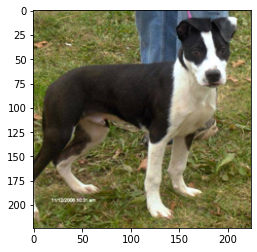

In [66]:
img = Image.open(fns[num]).convert('RGB').resize((224,224)) # convert 轉成彩色圖、resize重置圖片尺寸
plt.imshow(img)
# 圖片要進行預處理(或者應該說是數值標準化）
# 如果要使用別人的模型，不需要自己決定要怎麼預處理，要使用原本該模式的預處理方式
# 從keras拿的公版模型，裡面就有預處理的功能可以使用
from tensorflow.keras.applications.vgg16 import preprocess_input
img_np = np.array(img) # 要先轉成na.array才能進行數值標準化處理
preprocess_input(img_np)

In [60]:
# 因為圖片檔案太大，不建議使用fit一次去餵資料，會太佔記憶體
# 有兩種方式：1. fit_generator 2. train_on_batch/test_on_batch
# random.randint(0, 2(inclusive)): 0,1,2
# np.random,randint(0, 3(exclusive)): 0,1,2
def get_data(x, y, batch=20):
    idx = np.random.randint(0, len(x), size=batch)
    xidx, yidx = x[idx], y[idx]
    img_ori, img_pre, ans = [], [], []
    for xi, yi in zip(xidx, yidx):
        img = Image.open(xi).convert("RGB").resize((224, 224))
        img_np = np.array(img)
        img_p = preprocess_input(img_np)
        img_ori.append(img_np)
        img_pre.append(img_p)
        ans.append(yi)
    return np.array(img_ori), np.array(img_pre), np.array(ans)

In [61]:
from sklearn.model_selection import train_test_split
x, y = np.array(data["path"]), np.array(data["target"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
img_ori, img_pre, ans = get_data(x_train, y_train)
print(img_ori.shape) # 沒有經過數值預處理的圖片
print(img_pre.shape) # 已經經過數值標準化處理得圖片
print(ans.shape)

(20, 224, 224, 3)
(20, 224, 224, 3)
(20,)
